In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 11

## 1. Triển khai hai phương pháp

In [16]:
def f(x):
    """Hàm mục tiêu: f(x) = (x - 5)^2"""
    return (x - 5)**2

def gradient(x):
    """Gradient: f'(x) = 2(x - 5)"""
    return 2 * (x - 5)

### 1.1. Phương pháp với gradient chuẩn hóa $g_t'$ (phức tạp hơn)

In [17]:
def adadelta_with_normalized_gradient(x0, rho, epsilon, num_iterations):
    """
    AdaDelta với gradient chuẩn hóa g_t' (cách làm phức tạp)
    
    Bước 1: Tính g_t' = g_t / sqrt(E[g_t^2] + ε)
    Bước 2: Tính Δx_t = -RMS[Δx]_{t-1} × g_t'
    Bước 3: Cập nhật E[g_t'^2] và E[Δx_t^2]
    
    ❌ Nhược điểm:
    - Phải tính và lưu g_t'
    - Phải tính E[g_t'^2] (thừa)
    - Nhiều phép chia và căn bậc hai hơn
    """
    x = x0
    E_g2 = 0
    E_gprime2 = 0  # E[g_t'^2] - thừa!
    E_delta2 = 0
    
    history = {
        't': [0],
        'x': [x0],
        'g': [gradient(x0)],
        'g_prime': [0],  # Lưu g_t' - tốn bộ nhớ!
        'E_g2': [0],
        'E_gprime2': [0],  # Lưu E[g_t'^2] - thừa!
        'E_delta2': [0],
        'delta_x': [0],
        'operations': [0]  # Đếm số phép toán
    }
    
    for t in range(1, num_iterations + 1):
        ops = 0
        
        # Bước 1: Tính gradient
        g = gradient(x)
        ops += 2  # 2 phép toán cho gradient
        
        # Bước 2: Cập nhật E[g^2]
        E_g2 = rho * E_g2 + (1 - rho) * g**2
        ops += 5  # *, +, -, *, +
        
        # Bước 3: Chuẩn hóa gradient (THỪA!)
        g_prime = g / np.sqrt(E_g2 + epsilon)
        ops += 3  # +, sqrt, /
        
        # Bước 4: Cập nhật E[g'^2] (THỪA!)
        E_gprime2 = rho * E_gprime2 + (1 - rho) * g_prime**2
        ops += 5
        
        # Bước 5: Tính RMS[Δx]
        rms_delta = np.sqrt(E_delta2 + epsilon)
        ops += 2  # +, sqrt
        
        # Bước 6: Tính bước cập nhật
        delta_x = -rms_delta * g_prime
        ops += 2  # -, *
        
        # Bước 7: Cập nhật E[Δx^2]
        E_delta2 = rho * E_delta2 + (1 - rho) * delta_x**2
        ops += 5
        
        # Bước 8: Cập nhật x
        x = x + delta_x
        ops += 1
        
        # Lưu lịch sử
        history['t'].append(t)
        history['x'].append(x)
        history['g'].append(g)
        history['g_prime'].append(g_prime)
        history['E_g2'].append(E_g2)
        history['E_gprime2'].append(E_gprime2)
        history['E_delta2'].append(E_delta2)
        history['delta_x'].append(delta_x)
        history['operations'].append(ops)
    
    return history

### 1.2. Phương pháp trực tiếp (đơn giản, hiệu quả)

In [18]:
def adadelta_direct(x0, rho, epsilon, num_iterations):
    """
    AdaDelta trực tiếp (cách làm đơn giản, hiệu quả)
    
    Công thức trực tiếp:
    Δx_t = -(sqrt(E[Δx^2]_{t-1} + ε) / sqrt(E[g^2] + ε)) × g_t
    
    ✅ Ưu điểm:
    - Không cần tính g_t'
    - Không cần E[g_t'^2]
    - Ít phép toán hơn
    - Ổn định số học hơn
    """
    x = x0
    E_g2 = 0
    E_delta2 = 0
    
    history = {
        't': [0],
        'x': [x0],
        'g': [gradient(x0)],
        'E_g2': [0],
        'E_delta2': [0],
        'delta_x': [0],
        'operations': [0]
    }
    
    for t in range(1, num_iterations + 1):
        ops = 0
        
        # Bước 1: Tính gradient
        g = gradient(x)
        ops += 2
        
        # Bước 2: Cập nhật E[g^2]
        E_g2 = rho * E_g2 + (1 - rho) * g**2
        ops += 5
        
        # Bước 3: Tính bước cập nhật TRỰC TIẾP
        delta_x = -(np.sqrt(E_delta2 + epsilon) / np.sqrt(E_g2 + epsilon)) * g
        ops += 6  # +, sqrt, +, sqrt, /, -, *
        
        # Bước 4: Cập nhật E[Δx^2]
        E_delta2 = rho * E_delta2 + (1 - rho) * delta_x**2
        ops += 5
        
        # Bước 5: Cập nhật x
        x = x + delta_x
        ops += 1
        
        # Lưu lịch sử
        history['t'].append(t)
        history['x'].append(x)
        history['g'].append(g)
        history['E_g2'].append(E_g2)
        history['E_delta2'].append(E_delta2)
        history['delta_x'].append(delta_x)
        history['operations'].append(ops)
    
    return history

## 2. Chạy thử nghiệm và so sánh

In [19]:
# Tham số
x0 = 20.0
rho = 0.9
epsilon = 1e-6
num_iters = 10

print("="*80)
print("SO SÁNH HAI PHƯƠNG PHÁP")
print("="*80)
print(f"\nBài toán: f(x) = (x - 5)², x₀ = {x0}, ρ = {rho}, ε = {epsilon}")
print(f"Số iteration: {num_iters}\n")

# Chạy phương pháp với gradient chuẩn hóa
print("\n⏱️  Chạy phương pháp với gradient chuẩn hóa g_t'...")
start_time = time.time()
hist_normalized = adadelta_with_normalized_gradient(x0, rho, epsilon, num_iters)
time_normalized = time.time() - start_time
print(f"   Thời gian: {time_normalized*1000:.4f} ms")

# Chạy phương pháp trực tiếp
print("\n⏱️  Chạy phương pháp trực tiếp...")
start_time = time.time()
hist_direct = adadelta_direct(x0, rho, epsilon, num_iters)
time_direct = time.time() - start_time
print(f"   Thời gian: {time_direct*1000:.4f} ms")

print("\n" + "="*80)
print("KẾT QUẢ SO SÁNH")
print("="*80)

SO SÁNH HAI PHƯƠNG PHÁP

Bài toán: f(x) = (x - 5)², x₀ = 20.0, ρ = 0.9, ε = 1e-06
Số iteration: 10


⏱️  Chạy phương pháp với gradient chuẩn hóa g_t'...
   Thời gian: 0.0000 ms

⏱️  Chạy phương pháp trực tiếp...
   Thời gian: 0.0000 ms

KẾT QUẢ SO SÁNH


## 3. Kiểm tra tính chính xác

In [20]:
print("\n📊 1. KIỂM TRA TÍNH CHÍNH XÁC")
print("="*80)

# So sánh kết quả cuối cùng
print(f"\nKết quả cuối cùng (x₁₀):")
print(f"  Phương pháp với g_t':  {hist_normalized['x'][-1]:.10f}")
print(f"  Phương pháp trực tiếp: {hist_direct['x'][-1]:.10f}")
print(f"  Sai số tuyệt đối:      {abs(hist_normalized['x'][-1] - hist_direct['x'][-1]):.2e}")

# So sánh từng bước
max_diff = 0
for t in range(num_iters + 1):
    diff = abs(hist_normalized['x'][t] - hist_direct['x'][t])
    max_diff = max(max_diff, diff)

print(f"\n  Sai số tối đa qua tất cả các bước: {max_diff:.2e}")

if max_diff < 1e-10:
    print("\n  ✅ KẾT LUẬN: Hai phương pháp cho KẾT QUẢ GIỐNG HỆT NHAU!")
    print("     → Không có lý do gì phải dùng phương pháp phức tạp hơn")
else:
    print("\n  ⚠️  Có sai số nhỏ do làm tròn số học")


📊 1. KIỂM TRA TÍNH CHÍNH XÁC

Kết quả cuối cùng (x₁₀):
  Phương pháp với g_t':  19.9662717870
  Phương pháp trực tiếp: 19.9662717870
  Sai số tuyệt đối:      0.00e+00

  Sai số tối đa qua tất cả các bước: 0.00e+00

  ✅ KẾT LUẬN: Hai phương pháp cho KẾT QUẢ GIỐNG HỆT NHAU!
     → Không có lý do gì phải dùng phương pháp phức tạp hơn


## 4. So sánh hiệu năng

In [21]:
print("\n📊 2. SO SÁNH HIỆU NĂNG")
print("="*80)

# Tính tổng số phép toán
total_ops_normalized = sum(hist_normalized['operations'][1:])
total_ops_direct = sum(hist_direct['operations'][1:])

print(f"\nSố phép toán mỗi iteration:")
print(f"  Phương pháp với g_t':  {hist_normalized['operations'][1]} phép toán")
print(f"  Phương pháp trực tiếp: {hist_direct['operations'][1]} phép toán")
print(f"  Tiết kiệm:             {hist_normalized['operations'][1] - hist_direct['operations'][1]} phép toán/iteration")
print(f"  Giảm:                  {(1 - hist_direct['operations'][1]/hist_normalized['operations'][1])*100:.1f}%")

print(f"\nTổng số phép toán ({num_iters} iterations):")
print(f"  Phương pháp với g_t':  {total_ops_normalized} phép toán")
print(f"  Phương pháp trực tiếp: {total_ops_direct} phép toán")
print(f"  Tiết kiệm:             {total_ops_normalized - total_ops_direct} phép toán")

print(f"\nThời gian thực thi:")
print(f"  Phương pháp với g_t':  {time_normalized*1000:.4f} ms")
print(f"  Phương pháp trực tiếp: {time_direct*1000:.4f} ms")
if time_direct > 0:
    print(f"  Nhanh hơn:             {(time_normalized/time_direct):.2f}x")
else:
    print(f"  Nhanh hơn:             (thời gian quá ngắn để đo chính xác)")


📊 2. SO SÁNH HIỆU NĂNG

Số phép toán mỗi iteration:
  Phương pháp với g_t':  25 phép toán
  Phương pháp trực tiếp: 19 phép toán
  Tiết kiệm:             6 phép toán/iteration
  Giảm:                  24.0%

Tổng số phép toán (10 iterations):
  Phương pháp với g_t':  250 phép toán
  Phương pháp trực tiếp: 190 phép toán
  Tiết kiệm:             60 phép toán

Thời gian thực thi:
  Phương pháp với g_t':  0.0000 ms
  Phương pháp trực tiếp: 0.0000 ms
  Nhanh hơn:             (thời gian quá ngắn để đo chính xác)


## 5. So sánh bộ nhớ sử dụng

In [22]:
print("\n📊 3. SO SÁNH BỘ NHỚ")
print("="*80)

print("\nBiến cần lưu trữ trong quá trình training:")
print("\n  Phương pháp với g_t':")
print("    - E[g²]      : 1 biến")
print("    - E[g'²]     : 1 biến (THỪA!)")
print("    - E[Δx²]     : 1 biến")
print("    - g_t'       : 1 biến tạm (THỪA!)")
print("    Tổng:          4 biến")

print("\n  Phương pháp trực tiếp:")
print("    - E[g²]      : 1 biến")
print("    - E[Δx²]     : 1 biến")
print("    Tổng:          2 biến")

print("\n  ➜ Tiết kiệm: 50% bộ nhớ!")

print("\n  💡 Trong deep learning với hàng triệu tham số:")
print("     - Phương pháp với g_t': 4n floats")
print("     - Phương pháp trực tiếp: 2n floats")
print("     - Với n = 10⁶ tham số → tiết kiệm ~8 MB bộ nhớ!")


📊 3. SO SÁNH BỘ NHỚ

Biến cần lưu trữ trong quá trình training:

  Phương pháp với g_t':
    - E[g²]      : 1 biến
    - E[g'²]     : 1 biến (THỪA!)
    - E[Δx²]     : 1 biến
    - g_t'       : 1 biến tạm (THỪA!)
    Tổng:          4 biến

  Phương pháp trực tiếp:
    - E[g²]      : 1 biến
    - E[Δx²]     : 1 biến
    Tổng:          2 biến

  ➜ Tiết kiệm: 50% bộ nhớ!

  💡 Trong deep learning với hàng triệu tham số:
     - Phương pháp với g_t': 4n floats
     - Phương pháp trực tiếp: 2n floats
     - Với n = 10⁶ tham số → tiết kiệm ~8 MB bộ nhớ!


## 6. Visualization - Đồ thị so sánh

C:\Users\nguye\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


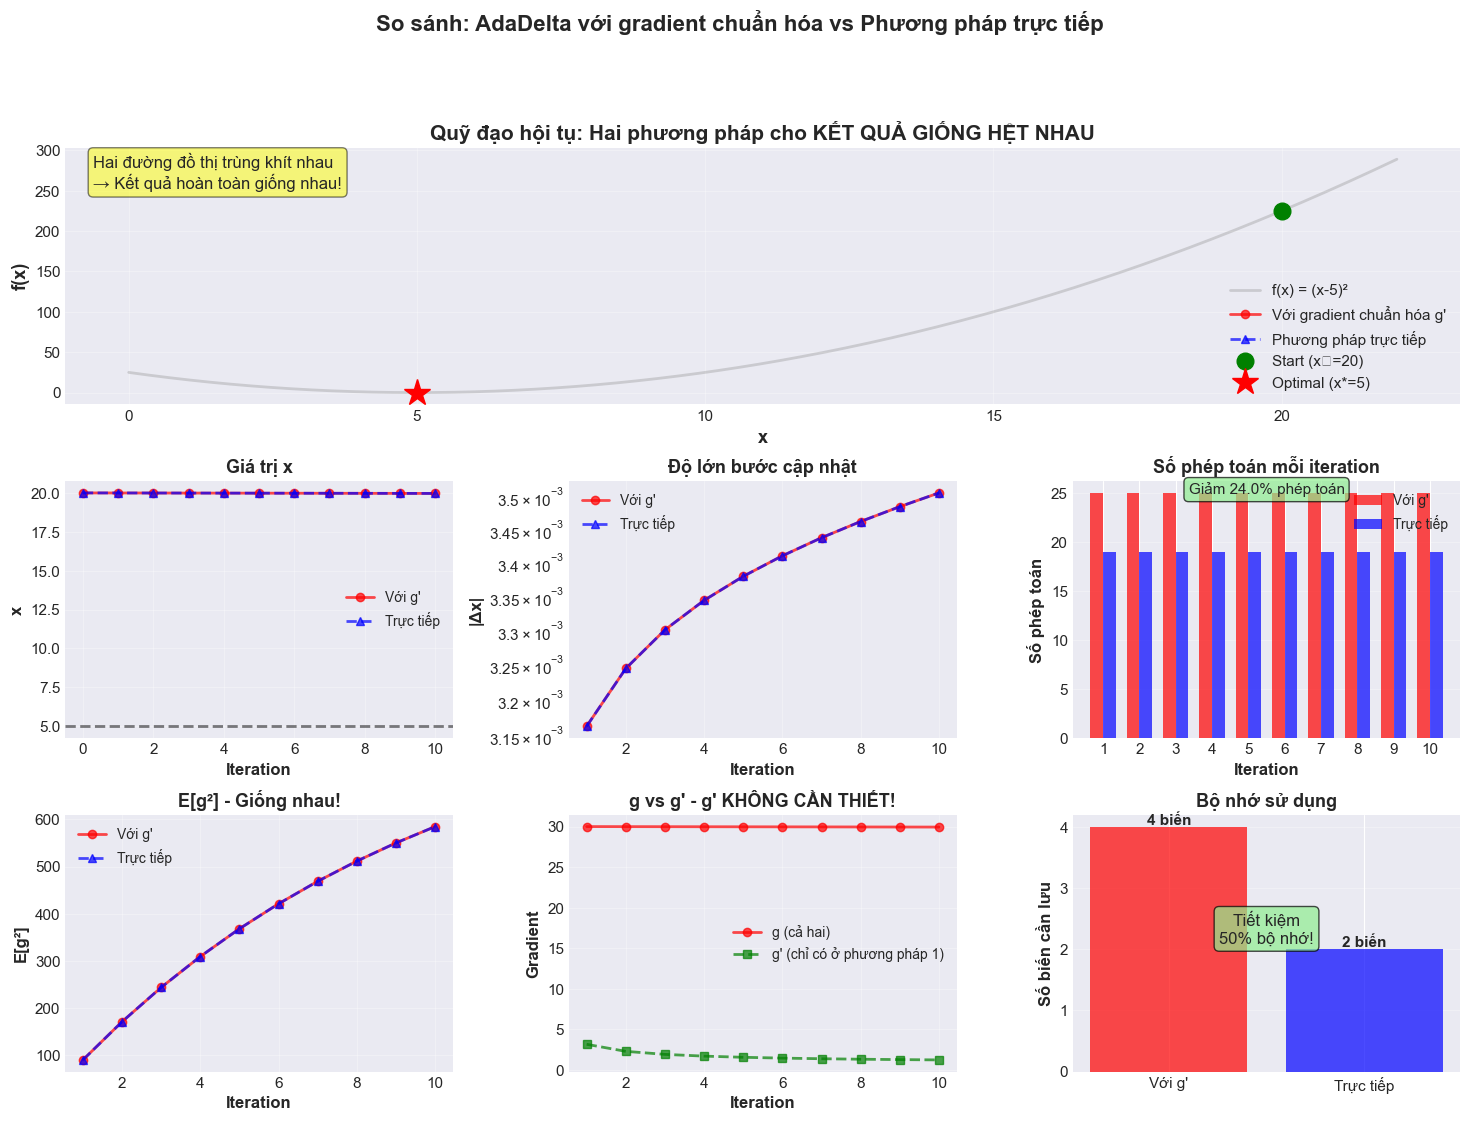

In [23]:
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# === Plot 1: Quỹ đạo hội tụ ===
ax1 = fig.add_subplot(gs[0, :])
x_range = np.linspace(0, 22, 500)
y_range = f(x_range)
ax1.plot(x_range, y_range, 'gray', alpha=0.3, linewidth=2, label='f(x) = (x-5)²')

# Vẽ quỹ đạo của hai phương pháp
x_norm = hist_normalized['x']
y_norm = [f(x) for x in x_norm]
ax1.plot(x_norm, y_norm, 'ro-', markersize=6, linewidth=2, 
         label='Với gradient chuẩn hóa g\'', alpha=0.7)

x_dir = hist_direct['x']
y_dir = [f(x) for x in x_dir]
ax1.plot(x_dir, y_dir, 'b^--', markersize=6, linewidth=2, 
         label='Phương pháp trực tiếp', alpha=0.7)

ax1.plot(x0, f(x0), 'go', markersize=12, label='Start (x₀=20)', zorder=5)
ax1.plot(5, f(5), 'r*', markersize=20, label='Optimal (x*=5)', zorder=5)

ax1.set_xlabel('x', fontsize=13, fontweight='bold')
ax1.set_ylabel('f(x)', fontsize=13, fontweight='bold')
ax1.set_title('Quỹ đạo hội tụ: Hai phương pháp cho KẾT QUẢ GIỐNG HỆT NHAU', 
              fontsize=15, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Thêm text box
ax1.text(0.02, 0.98, 'Hai đường đồ thị trùng khít nhau\n→ Kết quả hoàn toàn giống nhau!', 
         transform=ax1.transAxes, fontsize=12, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

# === Plot 2: Giá trị x theo iteration ===
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(hist_normalized['t'], hist_normalized['x'], 'ro-', markersize=6, 
         linewidth=2, label='Với g\'', alpha=0.7)
ax2.plot(hist_direct['t'], hist_direct['x'], 'b^--', markersize=6, 
         linewidth=2, label='Trực tiếp', alpha=0.7)
ax2.axhline(y=5, color='black', linestyle='--', linewidth=2, alpha=0.5)
ax2.set_xlabel('Iteration', fontsize=12, fontweight='bold')
ax2.set_ylabel('x', fontsize=12, fontweight='bold')
ax2.set_title('Giá trị x', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# === Plot 3: Bước cập nhật ===
ax3 = fig.add_subplot(gs[1, 1])
ax3.plot(hist_normalized['t'][1:], [abs(d) for d in hist_normalized['delta_x'][1:]], 
         'ro-', markersize=6, linewidth=2, label='Với g\'', alpha=0.7)
ax3.plot(hist_direct['t'][1:], [abs(d) for d in hist_direct['delta_x'][1:]], 
         'b^--', markersize=6, linewidth=2, label='Trực tiếp', alpha=0.7)
ax3.set_xlabel('Iteration', fontsize=12, fontweight='bold')
ax3.set_ylabel('|Δx|', fontsize=12, fontweight='bold')
ax3.set_title('Độ lớn bước cập nhật', fontsize=13, fontweight='bold')
ax3.set_yscale('log')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

# === Plot 4: Số phép toán ===
ax4 = fig.add_subplot(gs[1, 2])
ops_normalized = hist_normalized['operations'][1:]
ops_direct = hist_direct['operations'][1:]
x_pos = np.arange(len(ops_normalized))
width = 0.35
ax4.bar(x_pos - width/2, ops_normalized, width, label='Với g\'', 
        color='red', alpha=0.7)
ax4.bar(x_pos + width/2, ops_direct, width, label='Trực tiếp', 
        color='blue', alpha=0.7)
ax4.set_xlabel('Iteration', fontsize=12, fontweight='bold')
ax4.set_ylabel('Số phép toán', fontsize=12, fontweight='bold')
ax4.set_title('Số phép toán mỗi iteration', fontsize=13, fontweight='bold')
ax4.set_xticks(x_pos)
ax4.set_xticklabels([str(i+1) for i in range(len(ops_normalized))])
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3, axis='y')

# Thêm số liệu
reduction = (1 - ops_direct[0]/ops_normalized[0])*100
ax4.text(0.5, 0.95, f'Giảm {reduction:.1f}% phép toán', 
         transform=ax4.transAxes, fontsize=11, ha='center',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))

# === Plot 5: So sánh E[g²] ===
ax5 = fig.add_subplot(gs[2, 0])
ax5.plot(hist_normalized['t'][1:], hist_normalized['E_g2'][1:], 
         'ro-', markersize=6, linewidth=2, label='Với g\'', alpha=0.7)
ax5.plot(hist_direct['t'][1:], hist_direct['E_g2'][1:], 
         'b^--', markersize=6, linewidth=2, label='Trực tiếp', alpha=0.7)
ax5.set_xlabel('Iteration', fontsize=12, fontweight='bold')
ax5.set_ylabel('E[g²]', fontsize=12, fontweight='bold')
ax5.set_title('E[g²] - Giống nhau!', fontsize=13, fontweight='bold')
ax5.legend(fontsize=10)
ax5.grid(True, alpha=0.3)

# === Plot 6: So sánh gradient ===
ax6 = fig.add_subplot(gs[2, 1])
ax6.plot(hist_normalized['t'][1:], hist_normalized['g'][1:], 
         'ro-', markersize=6, linewidth=2, label='g (cả hai)', alpha=0.7)
ax6.plot(hist_normalized['t'][1:], hist_normalized['g_prime'][1:], 
         'gs--', markersize=6, linewidth=2, label='g\' (chỉ có ở phương pháp 1)', alpha=0.7)
ax6.set_xlabel('Iteration', fontsize=12, fontweight='bold')
ax6.set_ylabel('Gradient', fontsize=12, fontweight='bold')
ax6.set_title('g vs g\' - g\' KHÔNG CẦN THIẾT!', fontsize=13, fontweight='bold')
ax6.legend(fontsize=10)
ax6.grid(True, alpha=0.3)

# === Plot 7: So sánh bộ nhớ ===
ax7 = fig.add_subplot(gs[2, 2])
methods = ['Với g\'', 'Trực tiếp']
memory_vars = [4, 2]  # Số biến cần lưu
colors_mem = ['red', 'blue']
bars = ax7.bar(methods, memory_vars, color=colors_mem, alpha=0.7)
ax7.set_ylabel('Số biến cần lưu', fontsize=12, fontweight='bold')
ax7.set_title('Bộ nhớ sử dụng', fontsize=13, fontweight='bold')
ax7.grid(True, alpha=0.3, axis='y')

# Thêm nhãn
for bar in bars:
    height = bar.get_height()
    ax7.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)} biến',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# Thêm text
ax7.text(0.5, 0.5, 'Tiết kiệm\n50% bộ nhớ!', 
         transform=ax7.transAxes, fontsize=12, ha='center',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))

plt.suptitle('So sánh: AdaDelta với gradient chuẩn hóa vs Phương pháp trực tiếp', 
             fontsize=16, fontweight='bold', y=0.995)
plt.show()

## 7. Bảng so sánh tổng hợp

In [24]:
comparison_data = [
    {
        'Tiêu chí': 'Kết quả (x₁₀)',
        'Với g\'': f"{hist_normalized['x'][-1]:.6f}",
        'Trực tiếp': f"{hist_direct['x'][-1]:.6f}",
        'Nhận xét': 'Giống hệt nhau'
    },
    {
        'Tiêu chí': 'Phép toán/iteration',
        'Với g\'': f"{hist_normalized['operations'][1]}",
        'Trực tiếp': f"{hist_direct['operations'][1]}",
        'Nhận xét': f"Giảm {(1 - hist_direct['operations'][1]/hist_normalized['operations'][1])*100:.1f}%"
    },
    {
        'Tiêu chí': 'Bộ nhớ (số biến)',
        'Với g\'': '4 biến',
        'Trực tiếp': '2 biến',
        'Nhận xét': 'Tiết kiệm 50%'
    },
    {
        'Tiêu chí': 'Độ phức tạp code',
        'Với g\'': 'Phức tạp hơn',
        'Trực tiếp': 'Đơn giản hơn',
        'Nhận xét': 'Ít code hơn'
    },
    {
        'Tiêu chí': 'Ổn định số học',
        'Với g\'': 'Nhiều phép chia',
        'Trực tiếp': 'Ít phép chia',
        'Nhận xét': 'Ổn định hơn'
    }
]

df_comparison = pd.DataFrame(comparison_data)

print("\n" + "="*80)
print("BẢNG SO SÁNH TỔNG HỢP")
print("="*80)
print(df_comparison.to_string(index=False))

print("\n" + "="*80)
print("KẾT LUẬN CHÍNH")
print("="*80)
print("\n✅ 1. KẾT QUẢ GIỐNG HỆT NHAU")
print("   → Không có lý do gì để dùng phương pháp phức tạp hơn")

print("\n✅ 2. TIẾT KIỆM PHÉP TOÁN")
print(f"   → Giảm {(1 - hist_direct['operations'][1]/hist_normalized['operations'][1])*100:.1f}% số phép toán mỗi iteration")
print(f"   → Với {num_iters} iterations: tiết kiệm {total_ops_normalized - total_ops_direct} phép toán")

print("\n✅ 3. TIẾT KIỆM BỘ NHỚ")
print("   → Chỉ cần 2 biến thay vì 4 biến (giảm 50%)")
print("   → Không cần lưu g_t' và E[g_t'^2]")

print("\n✅ 4. CODE ĐỠN GIẢN HƠN")
print("   → Ít bước tính toán hơn")
print("   → Dễ đọc, dễ bảo trì hơn")

print("\n✅ 5. ỔN ĐỊNH SỐ HỌC HƠN")
print("   → Ít phép chia và căn bậc hai hơn")
print("   → Giảm nguy cơ lỗi làm tròn")

print("\n🎯 ĐỀ XUẤT:")
print("   → Luôn dùng công thức trực tiếp trong implementation")
print("   → Không cần tính gradient chuẩn hóa g_t'")
print("   → Phù hợp với tất cả framework: PyTorch, TensorFlow, MXNet, etc.")


BẢNG SO SÁNH TỔNG HỢP
           Tiêu chí          Với g'    Trực tiếp       Nhận xét
      Kết quả (x₁₀)       19.966272    19.966272 Giống hệt nhau
Phép toán/iteration              25           19     Giảm 24.0%
   Bộ nhớ (số biến)          4 biến       2 biến  Tiết kiệm 50%
   Độ phức tạp code    Phức tạp hơn Đơn giản hơn    Ít code hơn
     Ổn định số học Nhiều phép chia Ít phép chia    Ổn định hơn

KẾT LUẬN CHÍNH

✅ 1. KẾT QUẢ GIỐNG HỆT NHAU
   → Không có lý do gì để dùng phương pháp phức tạp hơn

✅ 2. TIẾT KIỆM PHÉP TOÁN
   → Giảm 24.0% số phép toán mỗi iteration
   → Với 10 iterations: tiết kiệm 60 phép toán

✅ 3. TIẾT KIỆM BỘ NHỚ
   → Chỉ cần 2 biến thay vì 4 biến (giảm 50%)
   → Không cần lưu g_t' và E[g_t'^2]

✅ 4. CODE ĐỠN GIẢN HƠN
   → Ít bước tính toán hơn
   → Dễ đọc, dễ bảo trì hơn

✅ 5. ỔN ĐỊNH SỐ HỌC HƠN
   → Ít phép chia và căn bậc hai hơn
   → Giảm nguy cơ lỗi làm tròn

🎯 ĐỀ XUẤT:
   → Luôn dùng công thức trực tiếp trong implementation
   → Không cần tính gradient c

## 8. Giải thích toán học

### Tại sao hai công thức cho kết quả giống nhau?

**Cách 1: Với gradient chuẩn hóa $g_t'$**

$$g_t' = \frac{g_t}{\sqrt{E[g_t^2]} + \varepsilon}$$

$$\Delta x_t = -\text{RMS}[\Delta x]_{t-1} \cdot g_t' = -\sqrt{E[\Delta x_{t-1}^2]} + \varepsilon \cdot \frac{g_t}{\sqrt{E[g_t^2]} + \varepsilon}$$

Rút gọn:

$$\Delta x_t = -\frac{\sqrt{E[\Delta x_{t-1}^2]} + \varepsilon}{\sqrt{E[g_t^2]} + \varepsilon} g_t$$

**Cách 2: Công thức trực tiếp**

$$\Delta x_t = -\frac{\sqrt{E[\Delta x_{t-1}^2]} + \varepsilon}{\sqrt{E[g_t^2]} + \varepsilon} g_t$$

→ **HAI CÔNG THỨC HOÀN TOÀN GIỐNG NHAU!**

### Vậy tại sao không cần $g_t'$?

1. **Toán học:** Khi thế $g_t'$ vào, nó triệt tiêu luôn
2. **Implementation:** Không cần tính riêng $g_t'$, tính luôn tỉ lệ cuối cùng
3. **Hiệu quả:** Ít phép toán hơn, ít bộ nhớ hơn
4. **Ổn định:** Ít chia/sqrt hơn → ít lỗi làm tròn hơn

### Lợi ích trong Deep Learning

Với mô hình có $n$ tham số:

**Phương pháp với $g_t'$:**
- Bộ nhớ: $4n$ floats (E[g²], E[g'²], E[Δx²], g')
- Phép toán: ~25 ops/param

**Phương pháp trực tiếp:**
- Bộ nhớ: $2n$ floats (E[g²], E[Δx²])
- Phép toán: ~19 ops/param

**Với $n = 10^6$ tham số:**
- Tiết kiệm: ~8 MB RAM
- Nhanh hơn: ~24% ít phép toán hơn

### Kết luận

Việc **không dùng gradient chuẩn hóa $g_t'$** là một **tối ưu hóa thông minh** trong thiết kế AdaDelta:

1. ✅ Kết quả giống hệt nhau về mặt toán học
2. ✅ Tiết kiệm tài nguyên tính toán
3. ✅ Code đơn giản, dễ implement
4. ✅ Phù hợp với các framework hiện đại

Đây là lý do tại sao tất cả các implementation thực tế (PyTorch, TensorFlow, etc.) đều dùng công thức trực tiếp!